# Bayesian Semi-parametric Soccer Goal Analysis Notebook

by Michael Wamberg & Bjarke Hastrup

# The equivalent poisson model

Survival function:  $$S(t)=exp\left(-\int_0^t \lambda(u)du\right)$$

Cox proportional hazard:$$\lambda_{ij} =\lambda_{j} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta})$$

Likelihood contribution from i'th individual, who dies or is censored in j'th time interval:    $\nu_i=1$ for death, 0 otherwise

\begin{align*}
L_i(\boldsymbol{\beta},\boldsymbol{\lambda} | D_{i})
&= (\lambda_{j} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}))^{\delta_{ij}\nu_{i}} \exp \left\{ - \delta_{ij} \left[ \lambda_{j}(y_{i} - s_{j-1}) + \sum^{j-1}_{g=1} \lambda_{g}(s_{g} - s_{g-1}) \right] \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}) \right\}\\
 &= \prod^{j}_{g=1} \exp \left\{ - \lambda_{g} t_{i,g} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}) \right\} (\lambda_{g} t_{i,g} \exp(\mathbf{x}_{i}^{T}\boldsymbol{\beta}))^{\delta_{i,g} \nu_{i}} \big/ (\delta_{i,g} \nu_{i})!\\
\end{align*}

We recognize this as poisson likelihood: $\frac{\mu e^{-\mu}}{k!}$.

$$
\log(\mu_{i,g})= \log(t_{i,g}) + \log(\lambda_{g}) + \mathbf{x}_{i}^{T}\boldsymbol{\beta}\\
$$


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels
import pystan
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import pystan_utils

#from pandas_ods_reader import read_ods

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

First we load in all our fitted STAN model to make this final notebook more compact.

In [2]:
# caches = dict()
# for n in range(1, 8):
#     file = np.load('cache2/model_{n}.npz'.format(n=n))
#     caches[n] = dict(file.items())
#     file.close()

#### Importing dataset

In [3]:
df = pd.read_csv('all_leagues_collected_clean.csv')
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,goal_time_h,goal_time_a,finished,red_cards_h,red_cards_a,BbAv>2.5,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,"3,83",91,94,NaN,NaN,2.03,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,"24,91",NaN,95,NaN,NaN,1.98,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,NaN,"41,80",95,NaN,NaN,1.95,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,NaN,"34,45,80",93,NaN,NaN,1.98,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,11,"8,18",95,NaN,NaN,2.01,4.74,3.53,1.89


#### Data description:

Div = League Division

Date = Match Date (dd/mm/yy)

HomeTeam = Home Team

AwayTeam = Away Team

FTHG = Full Time Home Team Goals

FTAG = Full Time Away Team Goals

goal_time_h = times for home team goals

goal_time_a = times for away team goals

finished = played number of minutes

red_cars_h = red card times for the home team

red_cards_a = red card times for the away team

BbAv>2.5 = Betbrain average over 2.5 goals

PSCH = Pinnacle home win odds

PSCD = Pinnacle draw odds

PSCA = Pinnacle away win odds

In [4]:
df.dtypes

Div             object
Date            object
HomeTeam        object
AwayTeam        object
FTHG             int64
FTAG             int64
goal_time_h     object
goal_time_a     object
finished         int64
red_cards_h     object
red_cards_a     object
BbAv>2.5       float64
PSCH           float64
PSCD           float64
PSCA           float64
dtype: object

Let us first look at how many matches we got per league

In [5]:
matches_por = df[df['Div'].str.contains("P1")].reset_index()
matches_eng = df[df['Div'].str.contains("E0")].reset_index()
matches_ita = df[df['Div'].str.contains("I1")].reset_index() 

print("The dataset contains", len(matches_por), "matches from Portugal,", len(matches_eng), "matches from England and", len(matches_ita), "matches from Italy")

The dataset contains 612 matches from Portugal, 760 matches from England and 760 matches from Italy


and how many of these matches ended with no goals?

In [6]:
home_goals_list = [df['FTHG'], matches_por['FTHG'], matches_eng['FTHG'], matches_ita['FTHG']]
away_goals_list = [df['FTAG'], matches_por['FTAG'], matches_eng['FTAG'], matches_ita['FTAG']]

no_goal_matches = np.empty(len(home_goals_list))

for i in range(len(home_goals_list)):
    for k,l in zip(home_goals_list[i], away_goals_list[i]):
        if k == 0 and l == 0:
            no_goal_matches[i] += 1
        
no_goal_total = no_goal_matches[0] / len(df) * 100
no_goal_por = no_goal_matches[1] / len(matches_por) * 100
no_goal_eng = no_goal_matches[2] / len(matches_eng) * 100
no_goal_ita = no_goal_matches[3] / len(matches_ita) * 100

print("In total: %.3f" % no_goal_total, "% of the matches ended with no goals")
print(" %.3f" % no_goal_por, "% of the matches in Portugal ended with no goals")
print(" %.3f" % no_goal_eng, "% of the matches in England ended with no goals")
print(" %.3f" % no_goal_ita, "% of the matches in Italy ended with no goals")

In total: 7.270 % of the matches ended with no goals
 6.373 % of the matches in Portugal ended with no goals
 7.105 % of the matches in England ended with no goals
 8.158 % of the matches in Italy ended with no goals


#### Visualization of data

The average number of goals from the 2017/18 and 2018/19 seasons in Portugal: 2.699
The average number of goals from the 2017/18 and 2018/19 seasons in England: 2.750
The average number of goals from the 2017/18 and 2018/19 seasons in Italy: 2.679


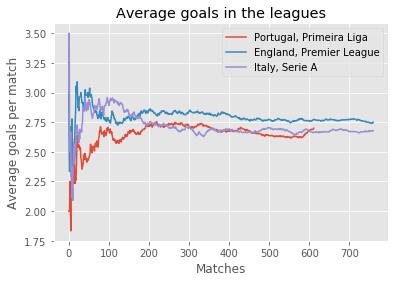

In [7]:
FTG_por = matches_por["FTHG"] + matches_por["FTAG"] # total number of goals per match in Portugal
FTG_eng = matches_eng["FTHG"] + matches_eng["FTAG"] # total number of goals per match in England
FTG_ita = matches_ita["FTHG"] + matches_ita["FTAG"] # # total number of goals per match in Italy

FTG_por_cumsum, FTG_eng_cumsum, FTG_ita_cumsum = [], [], []
FTG_por_av, FTG_eng_av, FTG_ita_av = [], [], []

for i in range(len(FTG_por)):
    FTG_por_cumsum.append(FTG_por[i])
    FTG_por_av.append(np.sum(FTG_por_cumsum) / (i+1))

for i in range(len(FTG_eng)):
    FTG_eng_cumsum.append(FTG_eng[i])
    FTG_eng_av.append(np.sum(FTG_eng_cumsum) / (i+1))

    FTG_ita_cumsum.append(FTG_ita[i])
    FTG_ita_av.append(np.sum(FTG_ita_cumsum) / (i+1))
    
plt.title("Average goals in the leagues")
plt.ylabel("Average goals per match")
plt.xlabel("Matches")
plt.plot(FTG_por_av, label="Portugal, Primeira Liga")
plt.plot(FTG_eng_av, label="England, Premier League")
plt.plot(FTG_ita_av, label="Italy, Serie A")
plt.legend()

print("The average number of goals from the 2017/18 and 2018/19 seasons in Portugal: %.3f" % np.mean(FTG_por))
print("The average number of goals from the 2017/18 and 2018/19 seasons in England: %.3f" % np.mean(FTG_eng))
print("The average number of goals from the 2017/18 and 2018/19 seasons in Italy: %.3f" % np.mean(FTG_ita))



# Data preprocessing

Here we are extracting the times for the first and second home goal. 

In the following the variable __t1__ will be the first goal scored in the match, while __t1_h__ and __t1_a__ note respectively the first goal for the home and away team. For the cases where the first goal in the match is scored by the home team, we set __dead1__ = 1, if the first goal in the match is scored by the away team or if no goals are scored in the whole match, then we have an censored observation, which is marked by letting __dead1__ = 0..

In order to observe a second goal, we need to have observed a first goal. Thus, we only "active" the second goal observation when we have observed a first goal. This first goal could be a home team goal or a away toam goal, and the same goes for the second goal. In the case where the second goal is scored by the away team we have an censored obersvation and we then let __dead2__ = 0. If instead the second is scored by the home team we note the scoring time and set __t2__ equal to this time and set __dead2__ = 1.

In [8]:
# start by recording the NaN values
ikke_nan_h = df['goal_time_h'].isnull() == False
ikke_nan_a = df['goal_time_a'].isnull() == False

In [9]:
df['t'] = df['finished'] # for first goal times
df['t1'] = df['finished'] # for first home goal times

df['dead'] = 0 # for censoring related to first goal
df['dead1'] = 0 # for censoring related to first home goal

# For second home goal times. Notice here that the observation only starts if we get a first goal in the match. Thus, we initialize with NaN
df['t2'] = np.nan
df['dead2'] = np.nan

for i in range(len(df)):
    if ikke_nan_h[i] == True:
        df.loc[i,'dead'] = 1
        string = df.loc[i,'goal_time_h']
        try:
            substr = string[:string.index(",")]
            df.loc[i, 't1_h'] = float(substr)
        except:
            substr = df.loc[i,'goal_time_h']
            df.loc[i,'t1_h'] = float(substr)
    
    if ikke_nan_a[i] == True:
        df.loc[i,'dead'] = 1
        string = df.loc[i,'goal_time_a']
        try:
            substr = string[:string.index(",")]
            df.loc[i,'t1_a'] = float(substr)
        except:
            substr = df.loc[i,'goal_time_a']
            df.loc[i,'t1_a'] = float(substr)
            
    # adding first goal times
    if ikke_nan_h[i] == True and ikke_nan_h[i] == True:
        first_goal = min(df.loc[i,'t1_h'], df.loc[i,'t1_a'])
    elif ikke_nan_h[i] == True:
        first_goal = df.loc[i,'t1_h']
    elif ikke_nan_a[i] == True:
        first_goal = df.loc[i,'t1_a']
    else:
        first_goal = df.loc[i,'finished']
    df.loc[i,'t1'] = first_goal
    
    if first_goal < df.loc[i,'t']:
        df.loc[i,'t'] = first_goal
    
    if df.loc[i,'t'] == df.loc[i,'t1_h']: # only counting the home goals
        df.loc[i,'dead1'] = 1

    
    # adding second goal times
    if df.loc[i, 'dead'] == 1: 
        
        # we got a first goal, so now we can activate t2 and dead2
        df.loc[i,'dead2'] = 0
        df.loc[i,'t2'] = df.loc[i, 'finished']
        
        if df.loc[i, 'dead1'] == 1: # in the case where the first goal was a home goal
            time_split_h = df.loc[i, 'goal_time_h'].split(",")
        
            n_goals_h = len(time_split_h)
                    
            if n_goals_h > 1:
                if ikke_nan_a[i] == True:
                    time_split_a = df.loc[i, 'goal_time_a'].split(",")
                    if time_split_a[0] > time_split_h[1]:
                        df.loc[i,'dead2'] = 1
                        df.loc[i,'t2'] = float(time_split_h[1])
                else:
                    df.loc[i,'dead2'] = 1
                    df.loc[i,'t2'] = float(time_split_h[1])
        
        # in the case where the first goal was a away goal
        if df.loc[i, 'dead1'] == 0 and ikke_nan_h[i] == True and ikke_nan_a[i] == True:
            time_split_h = df.loc[i, 'goal_time_h'].split(",")
            time_split_a = df.loc[i, 'goal_time_a'].split(",")
            
            if len(time_split_a) == 1:
                df.loc[i,'dead2'] = 1
                df.loc[i,'t2'] = float(time_split_h[0])
            elif time_split_h[0] < time_split_a[1]:
                df.loc[i,'dead2'] = 1
                df.loc[i,'t2'] = float(time_split_h[0])

In [10]:
df.head(20)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,goal_time_h,goal_time_a,finished,red_cards_h,...,PSCD,PSCA,t,t1,dead,dead1,t2,dead2,t1_h,t1_a
0,E0,10/08/2018,Man United,Leicester,2,1,"3,83",91,94,NaN,...,4.07,7.69,3.0,3.0,1,1,83.0,1.0,3.0,91.0
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,"24,91",NaN,95,NaN,...,3.61,4.70,24.0,24.0,1,1,91.0,1.0,24.0,NaN
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,NaN,"41,80",95,NaN,...,3.38,2.90,41.0,41.0,1,0,95.0,0.0,NaN,41.0
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,NaN,"34,45,80",93,NaN,...,3.95,1.58,34.0,34.0,1,0,93.0,0.0,NaN,34.0
4,E0,11/08/2018,Newcastle,Tottenham,1,2,11,"8,18",95,NaN,...,3.53,1.89,8.0,8.0,1,0,11.0,1.0,11.0,8.0
5,E0,11/08/2018,Watford,Brighton,2,0,"35,54",NaN,94,NaN,...,3.08,3.22,35.0,35.0,1,1,54.0,1.0,35.0,NaN
6,E0,11/08/2018,Wolves,Everton,2,2,"44,80","17,67",94,NaN,...,3.23,3.32,17.0,17.0,1,0,44.0,1.0,44.0,17.0
7,E0,12/08/2018,Arsenal,Man City,0,2,NaN,"14,64",94,NaN,...,4.13,1.81,14.0,14.0,1,0,94.0,0.0,NaN,14.0
8,E0,12/08/2018,Liverpool,West Ham,4,0,"19,45,53,88",NaN,93,NaN,...,6.95,12.00,19.0,19.0,1,1,45.0,1.0,19.0,NaN
9,E0,12/08/2018,Southampton,Burnley,0,0,NaN,NaN,95,NaN,...,3.19,4.65,95.0,95.0,0,0,NaN,NaN,NaN,NaN


Now we can look at when the first goal is generally scored in the three leagues

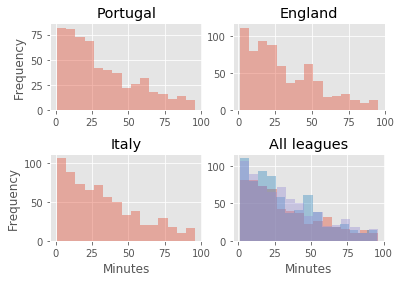

In [11]:
matches_por = df[df['Div'].str.contains("P1")].reset_index()
matches_eng = df[df['Div'].str.contains("E0")].reset_index()
matches_ita = df[df['Div'].str.contains("I1")].reset_index()

nondead_por = matches_por['dead'] == 1
nondead_eng = matches_eng['dead'] == 1
nondead_ita = matches_ita['dead'] == 1

matches_por_nondead = matches_por[nondead_por]
matches_eng_nondead = matches_eng[nondead_eng]
matches_ita_nondead = matches_ita[nondead_ita]


fig = plt.figure()
plt.subplots_adjust(hspace = 0.5)

plt.subplot(2, 2, 1, )
plt.title("Portugal")
plt.hist(matches_por_nondead['t'], bins=15, alpha=0.4)
plt.ylabel("Frequency")

plt.subplot(2, 2, 2)
plt.title("England")
plt.hist(matches_eng_nondead['t'], bins=15, alpha=0.4)

plt.subplot(2, 2, 3)
plt.title("Italy")
plt.hist(matches_ita_nondead['t'], bins=15, alpha=0.4)
plt.ylabel("Frequency")
plt.xlabel("Minutes")

plt.subplot(2, 2, 4)
plt.title("All leagues")
plt.hist(matches_por_nondead['t'], bins=15, alpha=0.4)
plt.hist(matches_eng_nondead['t'], bins=15, alpha=0.4)
plt.hist(matches_ita_nondead['t'], bins=15, alpha=0.4)
plt.xlabel("Minutes")

plt.show()

Next we setup an skill feature based on the available odds in the dataset. To do this most accurately, we must pay attention to how the bookmaker (Pinnacle) apply his margin. The odds quoted by Pinnacle on some match is related to the probabilities of the possible outcomes in this match. These probabilities do not add to 100% though, and the amount by which they exceed 100% constitutes Pinnacle's margin. Removing this margin should therefore reveal their true assessment of the match. Typically a greater margin is applied to the higher odds, since people prefer longshots compared to short odds - this is known as the favourite-longshot bias. Thus, the margin is removed relative to the size of odds

In [12]:
def normalise_odds(PSCH, PSCD, PSCA):
    """
    Normalise odds to probabilities by odds margin.
    margin weights in proportion to the size of the odds
    """
    probs = [1. / odds for odds in (PSCH, PSCD, PSCA)]
    margin = sum(probs)-1.
    trueo = [1./(3.* odds/(3.-margin*odds)) for odds in (PSCH, PSCD, PSCA)]
    
    return trueo

In [13]:
odds_columns = ['PSCH', 'PSCD', 'PSCA']

probabilities = df[odds_columns].apply(lambda row: normalise_odds(**row), axis=1)
cols = list(['home_win_prob','draw','away_win_prob'])
probabilities = pd.DataFrame(probabilities.values.tolist(), columns=cols)

df = df.merge(
    probabilities,
    left_index=True,
    right_index=True,
    suffixes=['', '_prob']
)

In [14]:
# To confirm our added columns
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,goal_time_h,goal_time_a,finished,red_cards_h,...,t1,dead,dead1,t2,dead2,t1_h,t1_a,home_win_prob,draw,away_win_prob
0,E0,10/08/2018,Man United,Leicester,2,1,"3,83",91,94,NaN,...,3.0,1,1,83.0,1.0,3.0,91.0,0.638194,0.238733,0.123072
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,"24,91",NaN,95,NaN,...,24.0,1,1,91.0,1.0,24.0,NaN,0.524685,0.269779,0.205536
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,NaN,"41,80",95,NaN,...,41.0,1,0,95.0,0.0,NaN,41.0,0.374224,0.288403,0.337373
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,NaN,"34,45,80",93,NaN,...,34.0,1,0,93.0,0.0,NaN,34.0,0.130056,0.245099,0.624846
4,E0,11/08/2018,Newcastle,Tottenham,1,2,11,"8,18",95,NaN,...,8.0,1,0,11.0,1.0,11.0,8.0,0.203185,0.275500,0.521315


Then we can look at how these probabilities match up with the actual results

Coefficient of determination: 0.9770063875622271


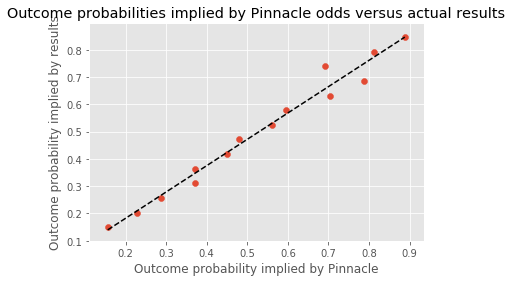

In [15]:
# Add full time result column
for i in range(len(df)):
    if df.loc[i, 'FTHG'] > df.loc[i, 'FTAG']:
        df.loc[i,'FTR'] = 'H'
    elif df.loc[i, 'FTHG'] < df.loc[i, 'FTAG']:
        df.loc[i,'FTR'] = 'A'
    else:
        df.loc[i,'FTR'] = 'D'
        
# discretize win probabilties
prob_range = np.linspace(0.15, 0.90, num=15)
prob_count = np.empty(len(prob_range))
win_count = np.empty(len(prob_range))

for i in range(len(df)):
    for j in range(len(prob_range)-1):
        if df.loc[i, 'home_win_prob'] > prob_range[j] and df.loc[i, 'home_win_prob'] < prob_range[j+1]:
            prob_count[j] += 1
            df.loc[i,'home_win_prob_disc'] = prob_range[j]        
            
        elif df.loc[i, 'away_win_prob'] > prob_range[j] and df.loc[i, 'away_win_prob'] < prob_range[j+1]:
            prob_count[j] += 1
            df.loc[i,'away_win_prob_disc'] = prob_range[j]

for i in range(len(df)):
    for j in range(len(prob_range)-1):
        if df.loc[i, 'home_win_prob_disc'] == prob_range[j] and df.loc[i, 'FTR'] == 'H':
            win_count[j] += 1
        elif df.loc[i, 'away_win_prob_disc'] == prob_range[j] and df.loc[i, 'FTR'] == 'A':
            win_count[j] += 1   
            
# Outcome probability implied by results
OPIR = win_count / prob_count

model = LinearRegression()
x = OPIR[:-1].reshape((-1, 1))
y = prob_range[:-1]
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
prediction=model.predict(np.sort(x, axis=0))
print('Coefficient of determination:', r_sq)

plt.title("Outcome probabilities implied by Pinnacle odds versus actual results")
plt.xlabel("Outcome probability implied by Pinnacle")
plt.ylabel("Outcome probability implied by results")
plt.scatter(x, y)
plt.plot(np.sort(x, axis=0),prediction, 'k--')
plt.show()

In order to avoid a _absolute value function-looking_-function, we create the skill gap feature below,  which goes to zero for two teams that are considered equally likely to win the match.

In [16]:
df['skill_gap'] = df['home_win_prob'] - df['away_win_prob']

In [17]:
df = df[df['Div'] == 'E0']

In [18]:
df = df[380:];

In [19]:
print(len(df))

380


In [20]:
df = df[np.isnan(np.asarray(df['skill_gap'])) == False]

In [21]:
#array([187, 187, 295, 295, 295, 295, 295, 295, 295, 295, 175, 175, 175,
#       175, 175, 175, 175, 175, 278, 278, 278, 278, 278])
#df.reset_index()[278:279][:]

Let us look at the first goal times versus this skill gap

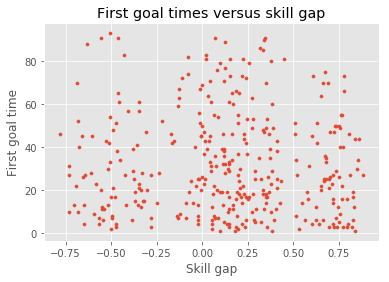

In [22]:
df_nondead_idx = df['dead'] == 1
df_nondead = df[df_nondead_idx]
df_nonead_sorted_sg = df_nondead.sort_values(by=['skill_gap'])

plt.title("First goal times versus skill gap")
plt.ylabel("First goal time")
plt.xlabel("Skill gap")
plt.scatter(df_nonead_sorted_sg['skill_gap'],df_nonead_sorted_sg['t'], s=10)

Forcing our skill gap to be within range [-1,1]

In [23]:
# scaler = preprocessing.StandardScaler()
# df.loc[:, 'skill_gap'] = scaler.fit_transform(np.asarray(df.loc[:, 'skill_gap']).reshape(-1, 1))
# df.dead = df.dead.astype(int)
# df.head()

In [24]:
n_patients = df.shape[0]
patients = np.arange(n_patients)

In [25]:
df_sort = df.sort_values(by=['t1'])

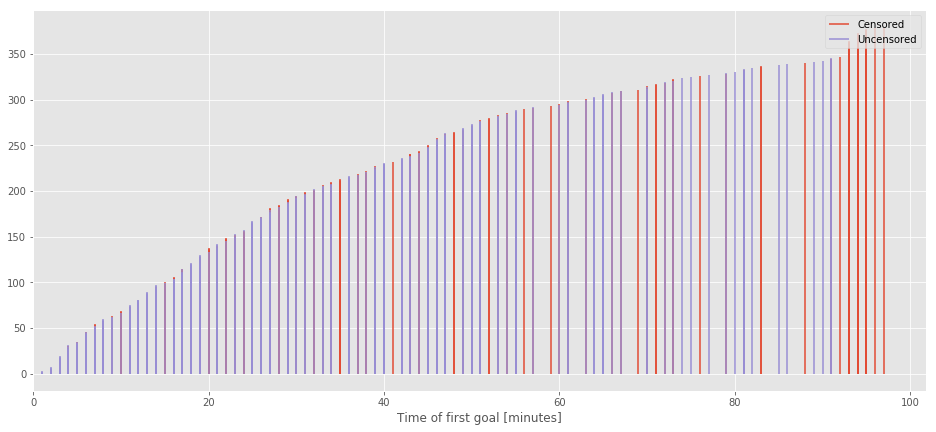

In [26]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16, 7))
blue, _, red = sns.color_palette()[:3]
ax.vlines(df_sort[df_sort.dead1.values == 0].t1, 0,  patients[df_sort.dead1.values == 0] ,
          color=blue, label='Censored');
ax.vlines(df_sort[df_sort.dead1.values == 1].t1 ,0, patients[df_sort.dead1.values == 1],
          color=red, label='Uncensored');

ax.set_xlim(left=0);
ax.set_xlabel('Time of first goal [minutes]');
ax.legend(loc='upper right');

In [27]:
interval_length = 4
interval_bounds = np.arange(1, df.finished.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

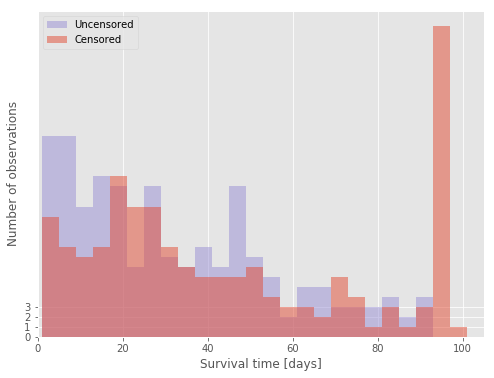

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df[df.dead1 == 1].t1.values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Uncensored');
ax.hist(df[df.dead1 == 0].t1.values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Censored');
ax.set_xlim(0, interval_bounds[-1]);
ax.set_xlabel('Survival time [days]');
ax.set_yticks([0, 1, 2, 3]);
ax.set_ylabel('Number of observations');
ax.legend();

Calculate exposure time (duration) for each time interval in each game.

In [29]:
last_period = np.floor((df.t1 - 0.01) / interval_length) # index of final exposure interval for goal no. 1
death = np.zeros((n_patients, n_intervals))              # initialize poisson observation array
death[patients, last_period.astype(int)] = df.dead1      # Censored or uncensored?

####  Calculate minutes of "first goal exposure" in each interval:
exposure = np.greater_equal.outer(df.t1, interval_bounds[:-1]) * interval_length 
exposure[patients, last_period.astype(int)] = df.t1 + 1 - interval_bounds[last_period.astype(int)]

To illustrate what's happening here, let us take a quick look at the arrays defined above:

In [30]:
print("The intervals bounds:")
print(interval_bounds); print();
print("Time of first goal for the first few matches in the dataset:")
print(df['t1'].head(10))
print()
print("Exposure arrays containing the number of minutes of exposure in each time interval for these 10 matches:")
print()
print(exposure[0:10])

The intervals bounds:
[  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  61  65  69
  73  77  81  85  89  93  97 101 105]

Time of first goal for the first few matches in the dataset:
380     2.0
381    70.0
382    24.0
383    23.0
384    46.0
385    93.0
386     8.0
387    31.0
388    33.0
389    61.0
Name: t1, dtype: float64

Exposure arrays containing the number of minutes of exposure in each time interval for these 10 matches:

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 4 4 4 4 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 0 0]
 [4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 4 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 0 0 0 0 0 0 0 0 0 0]]


Some final data preparation:

In [31]:
death_array = np.matrix.flatten(death).astype(int)
expo_array  = np.matrix.flatten(exposure)
skill_gap_array = np.asarray(df.skill_gap)
skill_gap_array = np.tile(skill_gap_array, (n_intervals, 1))
skill_gap_array = skill_gap_array.flatten('F')

df['goal'] = 0
x_goal = np.tile(np.asarray(df.goal), (n_intervals, 1)).flatten('F')
df['time_of_goal'] = 0
x_time_of_goal = np.tile(np.asarray(df.time_of_goal), (n_intervals, 1)).flatten('F')
df['time_from_goal'] = 0
x_time_from_goal = np.tile(np.asarray(df.time_from_goal), (n_intervals, 1)).flatten('F')


base_id = np.arange(1,n_intervals+1)
print(str(base_id.shape))
base_id = np.tile(base_id, len(df))

# Remove all pseudo poisson observations with zero exposure:
expo_new  = expo_array[expo_array > 0]
N_tot_new = len(expo_new)
base_id_new = base_id[expo_array > 0]
death_array_new = death_array[expo_array > 0]
skill_gap_array_new = skill_gap_array[expo_array > 0]
x_goal_new          = x_goal[expo_array > 0]
x_time_of_goal_new  = x_time_of_goal[expo_array > 0]
x_time_from_goal_new = x_time_from_goal[expo_array > 0]

(26,)


Likewise, we calculate the binary output (death2) and corresponding exposure matrix when one goal has already been scored. 

In [32]:
df2 = df[df['dead'] == 1] # Extracting matches where at least one goal has been scored. 
                          # This makes the match susceptible to a second goal.
n_patients2 = len(df2)
patients2 = np.arange(n_patients2)
print(str(n_patients2) + " matches with at least one goal scored.")

348 matches with at least one goal scored.


In [33]:
last_period2 = np.floor((df2.t2 - 0.01) / interval_length) # index of final exposure interval for goal no. 2
first_period2= np.floor((df2.t+1 - 0.01)/ interval_length) # index of first exposure interval for goal no. 2

death2 = np.zeros((n_patients2, n_intervals))              # Initialize pseudo poisson observation array
death2[patients2, last_period2.astype(int)] = df2.dead2    # Censored or uncensored?

####  Calculate minutes of "second goal exposure" in each interval:
exposure2 = (np.greater_equal.outer(df2.t2, interval_bounds[:-1]) 
             & np.less.outer(df2.t+1, interval_bounds[1:])) * interval_length
exposure2[patients2, last_period2.astype(int)]  = df2.t2 -  interval_bounds[last_period2.astype(int)] + 1
exposure2[patients2, first_period2.astype(int)] = interval_bounds[first_period2.astype(int) + 1] - (df2.t + 1)

Notice how for the second goal, the exposure period only begins after the first goal is scored and ends after any second goal (or end of match).

In [34]:
print(exposure2[0:10]) # Last columns corresponds to >95', hence no exposure for most typical matches. 

[[2 4 4 4 4 4 4 4 4 4 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 4 4 4 4 1 0 0]
 [0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 0 0]
 [0 0 0 0 0 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 4 4 4 4 4 4 4 4 4 4 4 2 0 0]
 [0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 0]
 [0 0 0 0 0 0 0 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 0 0]
 [0 0 0 0 0 0 0 0 3 4 4 4 4 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 4 4 4 4 4 4 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 4 4 4 4 0 0]]


In [35]:
death_array2 = np.matrix.flatten(death2).astype(int)
expo_array2  = np.matrix.flatten(exposure2)
skill_gap_array2 = np.asarray(df2.skill_gap)
skill_gap_array2 = np.tile(skill_gap_array2, (n_intervals, 1))
skill_gap_array2 = skill_gap_array2.flatten('F')



df2['goal'] = 1
x_goal2 = np.tile(np.asarray(df2.goal), (n_intervals, 1)).flatten('F')
df2['time_of_goal'] = df2.t
x_time_of_goal2 = np.tile(np.asarray(df2.time_of_goal), (n_intervals, 1)).flatten('F')

df2_from = np.tile(np.asarray(df2.dead), (n_intervals, 1))
for kamp in range(df2_from.shape[1]):
    for tid in range(df2_from.shape[0]):
        df2_from[tid,kamp] = interval_bounds[tid+1]+exposure2[kamp,tid]/2  - df.loc[df2.index[kamp],'t']



x_time_from_goal2 = df2_from.flatten('F')


base_id2 = np.arange(1,n_intervals+1)
print(str(base_id2.shape))
base_id2 = np.tile(base_id2, len(df2))

expo_new2        = expo_array2[expo_array2 > 0]
N_tot_new2       = len(expo_new2)
base_id_new2     = base_id2[expo_array2 > 0]
death_array_new2 = death_array2[expo_array2 > 0]
skill_gap_array_new2 = skill_gap_array2[expo_array2 > 0]
x_goal_new2          = x_goal2[expo_array2 > 0]
x_time_of_goal_new2  = x_time_of_goal2[expo_array2 > 0]
x_time_from_goal_new2  = x_time_from_goal2[expo_array2 > 0]

(26,)


/home/bjarke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/bjarke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [36]:
# Identify match ID for all pseudo poisson observation.
# This is neccesary for 'leave-one-match-out' cross validation in generated quantities in STAN model. 
match_index = df.index-df.index[0]
match2_index = df2.index-df.index[0]

match_id = []
for i in range(len(df)):
    match_id = np.concatenate((match_id, np.repeat(i,n_intervals)), axis=0)
match_id = match_id[expo_array > 0]

match_id2 = []
for i in range(len(df2)):
    match_id2 = np.concatenate((match_id2, np.repeat(match2_index[i],n_intervals)), axis=0)

match_id2 = match_id2[expo_array2 > 0]
match_id = np.concatenate((match_id, match_id2), axis=0)
match_id = match_id.astype(int)

# STAN model 1 - Independent gamma distributed baseline prior

Stan code for Cox proportional hazard model using i.i.d. informative gamma priors $\lambda_{0j} \sim gamma(1,5)$ for all baselines $1 \leq j \leq T$. (Here we are of course using the shape and rate representation of the gamma distribution.)

Only one covariate is considered here, which is the skill_gap (probability of home victory minus probability of away victory). Intuitively we would expect a larger skill_gap to speed up the arrival of a first home goal.
As prior for the covariate coeffient we have chosen $\beta \sim normal(0,3).$

In [53]:
independent_gamma="""
data {
  int<lower=1> N;          // number of matches
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  //int<lower=0> M;        // number of covariates
  vector[N_tot] x;         // covariate array
  int<lower=0, upper=T> base_id[N_tot];  // index of time interval for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // Observation array: 1 for observed goal, 
                                               // and 0 if no more goals or away goal.
  vector<lower=0>[N_tot] expo;  // Exposure time in each interval
  int match_id[N_tot];            // Which round does this pseudo poisson observation belong to?
  //int num_weeks;                // Number of rounds during a season.
}
transformed data {
  vector[N_tot] log_expo = log(expo);  // log-duration of exposure in each time interval
}
parameters {
  real beta;                       // regression coefficient of covariate(s)
  vector<lower=0>[T] lambda0;      // baseline hazard for each time interval
}
model {
  beta ~ normal(0, 3);
  
  lambda0 ~ gamma(0.1,0.1);
  //for (i in 2:T){
  //    lambda0[i] ~ normal(lambda0[i-1],0.04);
  //}
  death_array ~ poisson_log(log(lambda0[base_id]) + log_expo   + x * beta );
}
generated quantities {
  vector[N] log_lik = rep_vector(0,N);

  // PSIS-LOO, i.e. 'leave-one-match-out' cross validation.
  for (n_tot in 1:N_tot) { 
      log_lik[match_id[n_tot]+1] += poisson_log_lpmf(death_array[n_tot]| log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta);
  }
}
"""

In [54]:
sm = pystan.StanModel(model_code=independent_gamma);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc02a3bf8dfea8d6a468ba8f339e1b90 NOW.
/home/bjarke/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp1rahtmft/stanfit4anon_model_cc02a3bf8dfea8d6a468ba8f339e1b90_8789565968351012173.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [56]:
death_dat3 ={'N':      len(df),
             'N_tot':  N_tot_new + N_tot_new2,
             'T':      n_intervals,
             'M': 1,
             'base_id': np.concatenate((base_id_new, base_id_new2), axis=None),
             'death_array':   np.concatenate((death_array_new, death_array_new2), axis=None),
             'x': np.concatenate((skill_gap_array_new, skill_gap_array_new2), axis=None),
             'expo':    np.concatenate((expo_new, expo_new2), axis=None),
             'match_id': match_id}

In [57]:
fit = sm.sampling(data=death_dat3, algorithm="HMC", seed=1, iter=200, chains=4, warmup=50)

In [94]:
fit_ADVI = sm.vb(data=death_dat3, iter=10000, algorithm="meanfield", elbo_samples=300, grad_samples=1, seed=42, verbose=True)

In [58]:
import os
extract = fit.extract()
np.savez_compressed('cache2/model_0.npz', **extract, **fit.summary())

In [80]:
caches = dict()
for n in range(0, 2):
    file = np.load('cache2/model_{n}.npz'.format(n=n))
    caches[n] = dict(file.items())
    file.close()

(0, 0.1)

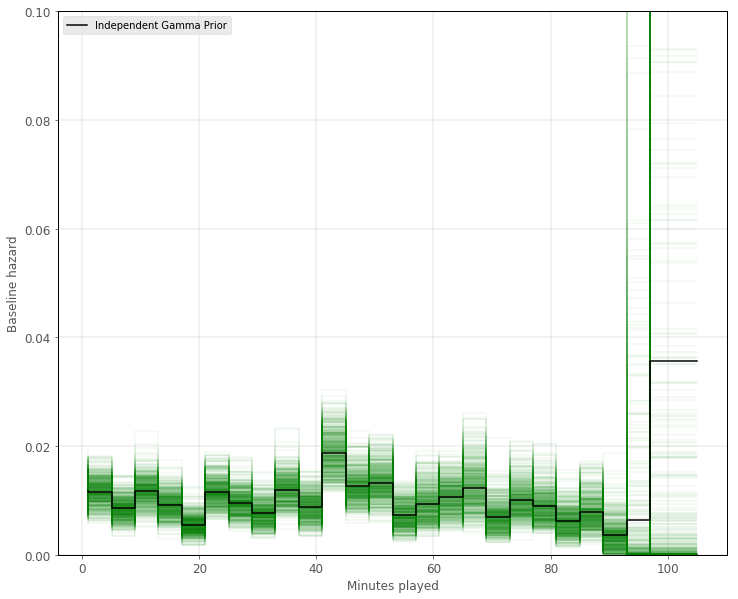

In [92]:
plt.figure(figsize=(12,10))

for i in range(600):
    plt.step(interval_bounds, np.concatenate((caches[0]['lambda0'][i], 
                                              caches[0]['lambda0'][i][-1]),axis=None),c='green' , linewidth=0.08)
plt.step(interval_bounds, np.concatenate((caches[0]['lambda0'].mean(axis=0), 
                                          caches[0]['lambda0'].mean(axis=0)[-1]),axis=None),c='black', label='Independent Gamma Prior')

plt.legend()
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.xlabel("Minutes played", fontsize=12)
plt.ylabel("Baseline hazard", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0, 0.10])

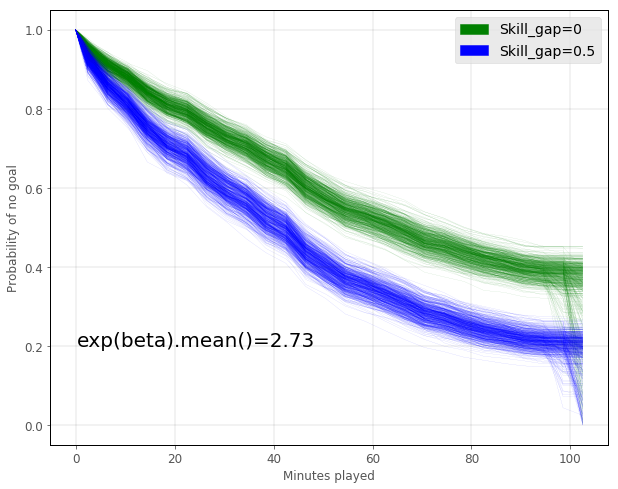

In [89]:
cum_hazard = np.zeros((27,600))
no_goal_prob = np.ones((27,600))
cum_hazard1 = np.zeros((27,600))
no_goal_prob1 = np.ones((27,600))

for i in range(600):
    for t in range(0,26):
        haz = caches[0]['lambda0'][i,t]*np.exp(0*caches[0]['beta'][i])
        cum_hazard[t+1,i] = haz + cum_hazard[t,i]
        no_goal_prob[t+1,i] = np.exp(-interval_length*cum_hazard[t+1,i])
        
for i in range(600):
    for t in range(0,26):
        haz = caches[0]['lambda0'][i,t]*np.exp(0.5*caches[0]['beta'][i])
        cum_hazard1[t+1,i] = haz + cum_hazard1[t,i]
        no_goal_prob1[t+1,i] = np.exp(-interval_length*cum_hazard1[t+1,i])

import matplotlib.patches as mpatches
plt.figure(figsize=(10,8))
green_patch = mpatches.Patch(color='green', label='Skill_gap=0')
blue_patch = mpatches.Patch(color='blue', label='Skill_gap=0.5')
plt.legend(handles=[green_patch, blue_patch], fontsize=14)
plt.text(0.2, 0.2, "exp(beta).mean()=" + str(np.round(np.exp(caches[0]['beta']).mean(),2)), fontsize=20)
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.xlabel("Minutes played", fontsize=12)
plt.ylabel("Probability of no goal", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
for i in range(600):
    plt.plot(np.concatenate((0, np.linspace(1,101,26)+1.5), axis=None), 
             no_goal_prob[0:,i], linewidth=0.05, c='green')
for i in range(600):
    plt.plot(np.concatenate((0, np.linspace(1,101,26)+1.5), axis=None), 
             no_goal_prob1[0:,i], linewidth=0.05, c='blue')

In [48]:
#np.diff(caches[1]['lambda0'].mean(axis=0), 1).std()

# Psis-loo

We measure the predictive accuracy of our fitted models by using leave-one-out cross-validation (LOO), which is estimated using existing draws from the posterior distribution via the Pareto-smoothed
importance sampling (PSIS) method, this combined method is known as the PSIS-LOO method \cite{aki}. For each iteration of LOO the log posterior predictive density is evaluated, then iterating $N$ times the expected log pointwise predictive density can be estimated by
\begin{equation}
    \text{elppd} = \sum_{m=1}^N \log p(y_m | \mathbf{y_{-m}} ) = \sum_{m=1}^N \int p(y_m | \theta) p(\theta | y) d \theta,
\end{equation}
where $\mathbf{y_{-m}}$ is our match data without the held-out match $m$.  
Approximating the LOO predictive density by importance sampling and applying a Pareto smoothing to the importance weights, the PSIS estimate of the LOO expected log pointwise predictive density can be written as
\begin{equation}
    \text{psis-elppd} = \sum_{m=1}^N \log
    \left(
    \frac{\sum_{s=1}^S w_m^s p(y_m|\theta^s)}{\sum_{s=1}^S w_m^s}
    \right),
\end{equation}
with $w^s_m$ being the Pareto smoothed importance weights. The Pareto smoothing is used to regularize the importance weights, which might otherwise be very large or even infinite.
Thus, by extracting the log-likelihoods for our models we can compute the PSIS estimates of LOO and compare them to see whether we have an improved model. We use the estimates of the Pareto distributions shape parameter $k$ in order to assess the  reliability of the PSIS estimates. It is shown that PSIS estimates are reliable when $k < 0.7$. 

See further details in:

Vehtari, A., Gelman, A., Gabry, J. (2017). "Practical
Bayesian model evaluation using leave-one-out
cross-validation and WAIC". Statistics and Computing.
27(5):1413–1432

and 

Vehtari, A., Simpson, D., Gelman, A., Yao, Y., Gabry,. J (2019). "Pareto Smoothed Importance Sampling".


In [49]:
from psis import psisloo

In [64]:
log_likelihood1 = caches[0]['log_lik'].reshape(600,-1)#caches[1]['log_lik'].reshape(600,-1)
loo, loos, ks = psisloo(log_likelihood1)
print(np.std(loos))

2.5955819936218534


Number of effective parameters:  24.679215726523125
Psis-loo estimate:  -1606.3335566916937


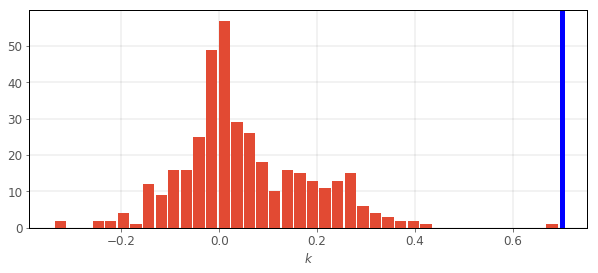

In [65]:
# estimated number of effective parameters
computed_lppd = np.sum(np.log(np.mean(np.exp(log_likelihood1),axis=0)));
pl00cv = computed_lppd - loo;
print("Number of effective parameters:  " + str(pl00cv))
print("Psis-loo estimate:  " + str(computed_lppd))
plt.figure(figsize=(10,4))
plt.hist(ks, bins=40, rwidth=0.9)
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
ylimits=ax.get_ylim()
plt.ylim(ylimits)
plt.plot([0.7, 0.7],[0,100],"b", linewidth=5)
plt.xlabel("$k$")
ax.tick_params(axis='both', which='major', labelsize=12)

# STAN Model 2 - Autoregressive baseline prior

Next up is the autoregressive baseline prior corresponding to a Gaussian process with a Brownian motion covariance function (with additional distribution constraint on the first time interval). 
```
lambda0[1] ~ gamma(0.1,0.1);
for (i in 2:T){
  lambda0[i] ~ normal(lambda0[i-1],0.02);
}
```
  

In [66]:
autoregressive="""
data {
  int<lower=1> N;          // number of matches
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  //int<lower=0> M;        // number of covariates
  vector[N_tot] x;         // covariate array
  int<lower=0, upper=T> base_id[N_tot];  // index of time interval for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // Observation array: 1 for observed goal, 
                                               // and 0 if no more goals or away goal.
  vector<lower=0>[N_tot] expo;  // Exposure time in each interval
  int match_id[N_tot];            // Which round does this pseudo poisson observation belong to?
  //int num_weeks;                // Number of rounds during a season.
}
transformed data {
  vector[N_tot] log_expo = log(expo);  // log-duration of exposure in each time interval
}
parameters {
  real beta;                       // regression coefficient of covariate(s)
  vector<lower=0>[T] lambda0;      // baseline hazard for each time interval
}
model {
  beta ~ normal(0, 3);
  
  lambda0[1] ~ gamma(0.1,0.1);
  for (i in 2:T){
      lambda0[i] ~ normal(lambda0[i-1],0.02);
  }
  death_array ~ poisson_log(log(lambda0[base_id]) + log_expo   + x * beta );
}
generated quantities {
  vector[N] log_lik = rep_vector(0,N);

  // PSIS-LOO, i.e. 'leave-one-match-out' cross validation.
  for (n_tot in 1:N_tot) { 
      log_lik[match_id[n_tot]+1] += poisson_log_lpmf(death_array[n_tot]| log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta);
  }
}
"""

In [67]:
sm = pystan.StanModel(model_code=autoregressive);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_655665d9c91bc0658365043f03c166e9 NOW.
/home/bjarke/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpsjept005/stanfit4anon_model_655665d9c91bc0658365043f03c166e9_5484512533267460574.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [68]:
death_dat3 ={'N':      len(df),
             'N_tot':  N_tot_new + N_tot_new2,
             'T':      n_intervals,
             'M': 1,
             'base_id': np.concatenate((base_id_new, base_id_new2), axis=None),
             'death_array':   np.concatenate((death_array_new, death_array_new2), axis=None),
             'x': np.concatenate((skill_gap_array_new, skill_gap_array_new2), axis=None),
             'expo':    np.concatenate((expo_new, expo_new2), axis=None),
             'match_id': match_id}

In [69]:
fit = sm.sampling(data=death_dat3, algorithm="HMC", seed=1, iter=200, chains=4, warmup=50)

In [94]:
fit_ADVI = sm.vb(data=death_dat3, iter=10000, algorithm="meanfield", elbo_samples=300, grad_samples=1, seed=42, verbose=True)

In [70]:
import os
#os.mkdir('cache2')
#sm_gp = pystan.StanModel(model_code=gp_model, model_name='Model_gp_baseline')
#fit_gp = sm_gp.sampling(data=death_dat4, algorithm="HMC", seed=3, iter=200, chains=4, warmup=50)
extract = fit.extract()
np.savez_compressed('cache2/model_1.npz', **extract, **fit.summary())

In [71]:
caches = dict()
for n in range(1, 2):
    file = np.load('cache2/model_{n}.npz'.format(n=n))
    caches[n] = dict(file.items())
    file.close()

In [72]:
fit

Inference for Stan model: anon_model_655665d9c91bc0658365043f03c166e9.
4 chains, each with iter=200; warmup=50; thin=1; 
post-warmup draws per chain=150, total post-warmup draws=600.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta            0.9  5.3e-3   0.13   0.65    0.8    0.9   0.99   1.15    600   1.02
lambda0[0]     0.01  2.1e-4 2.5e-3 7.9e-3   0.01   0.01   0.01   0.02    144   1.03
lambda0[1]     0.01  1.1e-4 2.6e-3 7.8e-3   0.01   0.01   0.01   0.02    600   1.04
lambda0[2]   9.5e-3  8.5e-5 2.1e-3 5.8e-3 8.0e-3 9.4e-3   0.01   0.01    600   1.03
lambda0[3]     0.01  1.9e-4 2.6e-3 7.5e-3   0.01   0.01   0.01   0.02    186   1.01
lambda0[4]   9.9e-3  8.7e-5 2.1e-3 6.4e-3 8.3e-3 9.8e-3   0.01   0.01    600   1.05
lambda0[5]   6.1e-3  7.0e-5 1.7e-3 3.2e-3 4.9e-3 5.9e-3 7.1e-3 9.8e-3    600   1.01
lambda0[6]     0.01  9.7e-5 2.4e-3 8.3e-3   0.01   0.01   0.01   0.02    600   1.02
lambda0[7]     0.01  9.8e-5 2.4e-3 6.4e-3 9.4e-3   0.01   0.

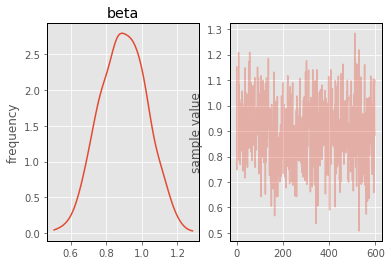

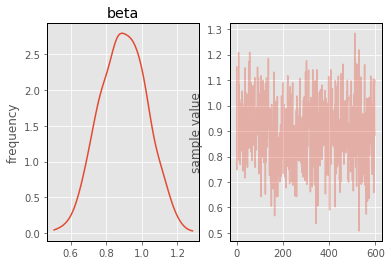

In [73]:
fit.traceplot(['beta'])

(0, 0.1)

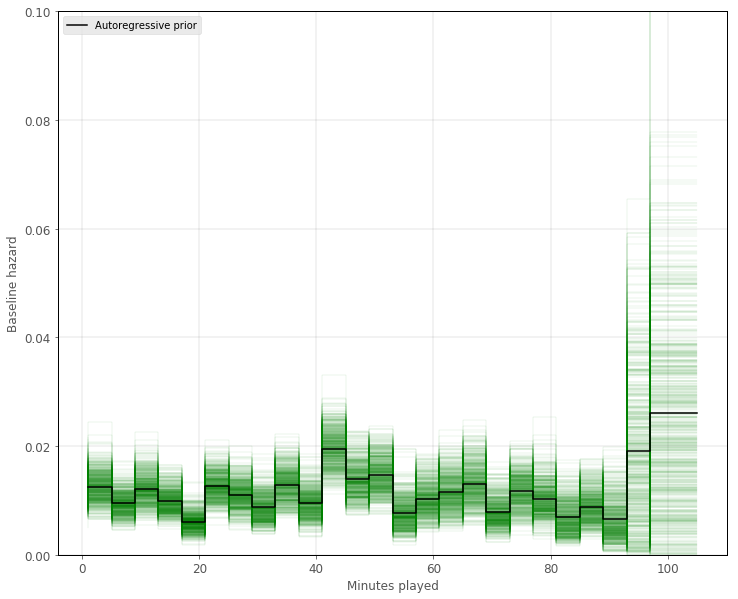

In [74]:
plt.figure(figsize=(12,10))

for i in range(600):
    plt.step(interval_bounds, np.concatenate((caches[1]['lambda0'][i], 
                                              caches[1]['lambda0'][i][-1]),axis=None),c='green' , linewidth=0.08)
plt.step(interval_bounds, np.concatenate((caches[1]['lambda0'].mean(axis=0), 
                                          caches[1]['lambda0'].mean(axis=0)[-1]),axis=None),c='black', label='Autoregressive prior')

plt.legend()
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.xlabel("Minutes played", fontsize=12)
plt.ylabel("Baseline hazard", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0, 0.10])

Here we notice that by introducing the random walk type baseline hazard, hazards are now more regularized than in the independent gamma prior model (Model 0). This also causes a slight decrese in the effective number of parameters from 24.7 to 22.0.

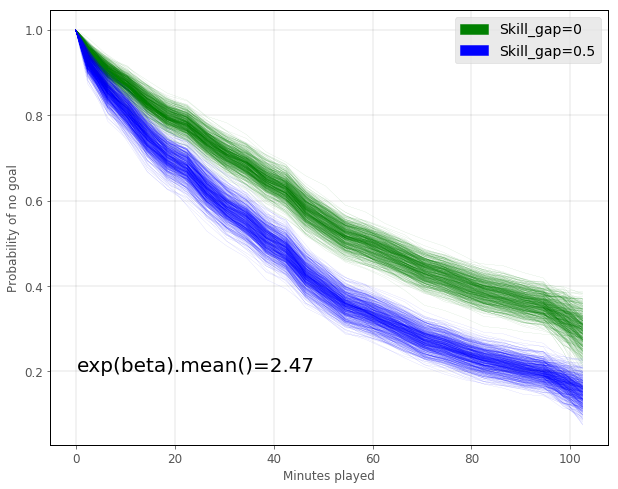

In [75]:
cum_hazard = np.zeros((27,600))
no_goal_prob = np.ones((27,600))
cum_hazard1 = np.zeros((27,600))
no_goal_prob1 = np.ones((27,600))

for i in range(600):
    for t in range(0,26):
        haz = caches[1]['lambda0'][i,t]*np.exp(0*caches[1]['beta'][i])
        cum_hazard[t+1,i] = haz + cum_hazard[t,i]
        no_goal_prob[t+1,i] = np.exp(-interval_length*cum_hazard[t+1,i])
        
for i in range(600):
    for t in range(0,26):
        haz = caches[1]['lambda0'][i,t]*np.exp(0.5*caches[1]['beta'][i])
        cum_hazard1[t+1,i] = haz + cum_hazard1[t,i]
        no_goal_prob1[t+1,i] = np.exp(-interval_length*cum_hazard1[t+1,i])

import matplotlib.patches as mpatches
plt.figure(figsize=(10,8))
green_patch = mpatches.Patch(color='green', label='Skill_gap=0')
blue_patch = mpatches.Patch(color='blue', label='Skill_gap=0.5')
plt.legend(handles=[green_patch, blue_patch], fontsize=14)
plt.text(0.2, 0.2, "exp(beta).mean()=" + str(np.round(np.exp(caches[1]['beta']).mean(),2)), fontsize=20)
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.xlabel("Minutes played", fontsize=12)
plt.ylabel("Probability of no goal", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
for i in range(600):
    plt.plot(np.concatenate((0, np.linspace(1,101,26)+1.5), axis=None), 
             no_goal_prob[0:,i], linewidth=0.05, c='green')
for i in range(600):
    plt.plot(np.concatenate((0, np.linspace(1,101,26)+1.5), axis=None), 
             no_goal_prob1[0:,i], linewidth=0.05, c='blue')

In [48]:
#np.diff(caches[1]['lambda0'].mean(axis=0), 1).std()

# Psis-loo

In [76]:
from psis import psisloo

In [77]:
log_likelihood1 = caches[1]['log_lik'].reshape(600,-1)#caches[1]['log_lik'].reshape(600,-1)
loo, loos, ks = psisloo(log_likelihood1)
print(np.std(loos))

2.5322371341797867


Number of effective parameters:  22.0434428203896
Psis-loo estimate:  -1607.9849453291308


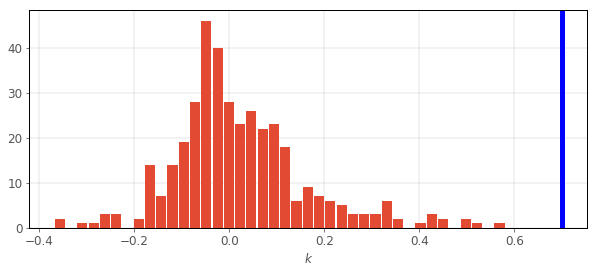

In [78]:
# estimated number of effective parameters
computed_lppd = np.sum(np.log(np.mean(np.exp(log_likelihood1),axis=0)));
pl00cv = computed_lppd - loo;
print("Number of effective parameters:  " + str(pl00cv))
print("Psis-loo estimate:  " + str(computed_lppd))
plt.figure(figsize=(10,4))
plt.hist(ks, bins=40, rwidth=0.9)
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
ylimits=ax.get_ylim()
plt.ylim(ylimits)
plt.plot([0.7, 0.7],[0,100],"b", linewidth=5)
plt.xlabel("$k$")
ax.tick_params(axis='both', which='major', labelsize=12)

# STAN Model - more covariates

In [127]:
goal_feature="""
data {
  int<lower=1> N;          // number of matches
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  int<lower=0> M;          // number of covariates
  vector[N_tot] x;         // skill_gap feature
  vector[N_tot] x_goal;    // goal feature - 1 if one goal already scored, else 0.
  int<lower=0, upper=T> base_id[N_tot];  // index of time interval for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // Observation array: 1 for observed goal, 
                                               // and 0 if no more goals or away goal.
  vector<lower=0>[N_tot] expo;  // Exposure time in each interval
  int match_id[N_tot];            // Which round does this pseudo poisson observation belong to?
  //int num_weeks;                // Number of rounds during a season.
}
transformed data {
  vector[N_tot] log_expo = log(expo);  // log-duration of exposure in each time interval
}
parameters {
  real beta[M];                       // regression coefficient of covariate(s)
  vector<lower=0>[T] lambda0;         // baseline hazard for each time interval
}
model {
  beta ~ normal(0, 3);
  
  lambda0[1] ~ gamma(0.1,0.1);
  for (i in 2:T){
      lambda0[i] ~ normal(lambda0[i-1],0.02);
  }
  death_array ~ poisson_log(log(lambda0[base_id]) + log_expo + x * beta[1] + x_goal * beta[2]);
}
generated quantities {
  vector[N] log_lik = rep_vector(0,N);

  // PSIS-LOO, i.e. 'leave-one-match-out' cross validation.
  for (n_tot in 1:N_tot) { 
      log_lik[match_id[n_tot]+1] += poisson_log_lpmf(death_array[n_tot]| log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta[1]+x_goal[n_tot]*beta[2]);
  }
}
"""

In [128]:
sm = pystan.StanModel(model_code=goal_feature);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ed3eb4129cd17ad84f5891975ea2ab7 NOW.
/home/bjarke/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpz7517ay5/stanfit4anon_model_7ed3eb4129cd17ad84f5891975ea2ab7_5579655960901026336.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [116]:
death_dat3 ={'N':      len(df),
             'N_tot':  N_tot_new + N_tot_new2,
             'T':      n_intervals,
             'M': 2,
             'base_id':       np.concatenate((base_id_new, base_id_new2), axis=None),
             'death_array':   np.concatenate((death_array_new, death_array_new2), axis=None),
             'x':             np.concatenate((skill_gap_array_new, skill_gap_array_new2), axis=None),
             'x_goal':        np.concatenate((x_goal_new, x_goal_new2), axis=None),
             'x_time_of':     np.concatenate((x_time_of_goal_new, x_time_of_goal_new2), axis=None),
             'x_time_from':   np.concatenate((x_time_from_goal_new, x_time_from_goal_new2), axis=None),
             'expo':          np.concatenate((expo_new, expo_new2), axis=None),
             'match_id': match_id}

In [129]:
fit = sm.sampling(data=death_dat3, algorithm="HMC", seed=1, iter=200, chains=4, warmup=50)

In [94]:
fit_ADVI = sm.vb(data=death_dat3, iter=10000, algorithm="meanfield", elbo_samples=300, grad_samples=1, seed=42, verbose=True)

In [130]:
import os
#os.mkdir('cache2')
#sm_gp = pystan.StanModel(model_code=gp_model, model_name='Model_gp_baseline')
#fit_gp = sm_gp.sampling(data=death_dat4, algorithm="HMC", seed=3, iter=200, chains=4, warmup=50)
extract = fit.extract()
np.savez_compressed('cache2/model_2.npz', **extract, **fit.summary())

In [131]:
caches = dict()
for n in range(2,3):
    file = np.load('cache2/model_{n}.npz'.format(n=n))
    caches[n] = dict(file.items())
    file.close()

In [133]:
fit

Inference for Stan model: anon_model_7ed3eb4129cd17ad84f5891975ea2ab7.
4 chains, each with iter=200; warmup=50; thin=1; 
post-warmup draws per chain=150, total post-warmup draws=600.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]        0.91    0.02   0.14   0.67   0.81   0.92   1.01    1.2     34   1.09
beta[1]        -0.4  9.7e-3   0.11   -0.6  -0.48   -0.4  -0.32  -0.17    137   1.03
lambda0[0]     0.01  1.1e-4 2.6e-3 7.6e-3   0.01   0.01   0.01   0.02    600    1.0
lambda0[1]     0.01  1.2e-4 2.9e-3 7.4e-3   0.01   0.01   0.01   0.02    600   1.01
lambda0[2]   9.5e-3  8.7e-5 2.1e-3 6.0e-3 7.9e-3 9.4e-3   0.01   0.01    600   1.01
lambda0[3]     0.01  1.1e-4 2.7e-3 8.1e-3   0.01   0.01   0.01   0.02    600    1.0
lambda0[4]     0.01  9.9e-5 2.4e-3 6.5e-3 8.9e-3   0.01   0.01   0.02    600   1.02
lambda0[5]   6.9e-3  2.2e-4 2.1e-3 3.4e-3 5.3e-3 6.6e-3 8.2e-3   0.01     98   1.03
lambda0[6]     0.01  1.2e-4 2.9e-3 8.3e-3   0.01   0.01   0.

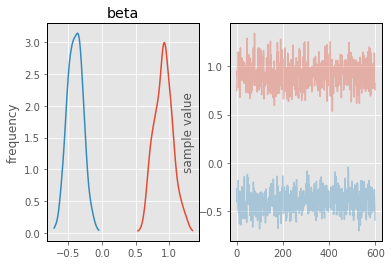

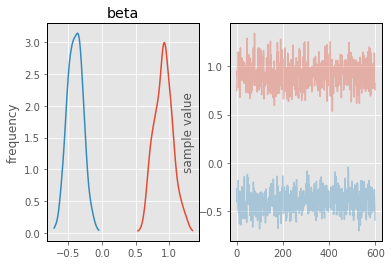

In [135]:
fit.traceplot(['beta'])

Here we notice that by introducing the random walk type baseline hazard, hazards are now more regularized than in the independent gamma prior model (Model 0). This also causes a slight decrese in the effective number of parameters from 24.7 to 22.0.

In [48]:
#np.diff(caches[1]['lambda0'].mean(axis=0), 1).std()

# Psis-loo

In [76]:
from psis import psisloo

In [136]:
log_likelihood1 = caches[2]['log_lik'].reshape(600,-1)#caches[1]['log_lik'].reshape(600,-1)
loo, loos, ks = psisloo(log_likelihood1)
print(np.std(loos))

2.539929205115155


Number of effective parameters:  23.383330702874446
Psis-loo estimate:  -1605.9139453683574


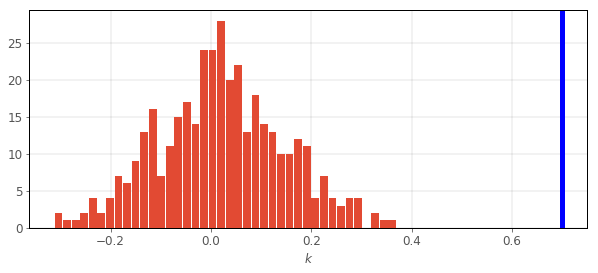

In [137]:
# estimated number of effective parameters
computed_lppd = np.sum(np.log(np.mean(np.exp(log_likelihood1),axis=0)));
pl00cv = computed_lppd - loo;
print("Number of effective parameters:  " + str(pl00cv))
print("Psis-loo estimate:  " + str(computed_lppd))
plt.figure(figsize=(10,4))
plt.hist(ks, bins=40, rwidth=0.9)
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
ylimits=ax.get_ylim()
plt.ylim(ylimits)
plt.plot([0.7, 0.7],[0,100],"b", linewidth=5)
plt.xlabel("$k$")
ax.tick_params(axis='both', which='major', labelsize=12)

# STAN Model - Time of goal and time since goal

In [45]:
goal_feature_time="""
data {
  int<lower=1> N;          // number of matches
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  int<lower=0> M;          // number of covariates
  vector[N_tot] x;         // skill_gap feature
  vector[N_tot] x_goal;    // goal feature - 1 if one goal already scored, else 0.
  vector[N_tot] x_time_of;    // time of first goal 
  vector[N_tot] x_time_from;  // time since first goal
  
  int<lower=0, upper=T> base_id[N_tot];  // index of time interval for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // Observation array: 1 for observed goal, 
                                               // and 0 if no more goals or away goal.
  vector<lower=0>[N_tot] expo;  // Exposure time in each interval
  int match_id[N_tot];            // Which round does this pseudo poisson observation belong to?
  //int num_weeks;                // Number of rounds during a season.
}
transformed data {
  vector[N_tot] log_expo = log(expo);  // log-duration of exposure in each time interval
}
parameters {
  real beta[M];                       // regression coefficient of covariate(s)
  vector<lower=0>[T] lambda0;         // baseline hazard for each time interval
}
model {
  beta ~ normal(0, 3);
  
  lambda0[1] ~ gamma(0.1,0.1);
  for (i in 2:T){
      lambda0[i] ~ normal(lambda0[i-1],0.02);
  }
  death_array ~ poisson_log(log(lambda0[base_id]) + log_expo + x*beta[1] + x_goal*beta[2] + x_time_of*beta[3] + x_time_from*beta[4]);
}
generated quantities {
  vector[N] log_lik = rep_vector(0,N);

  // PSIS-LOO, i.e. 'leave-one-match-out' cross validation.
  for (n_tot in 1:N_tot) { 
      log_lik[match_id[n_tot]+1] += poisson_log_lpmf(death_array[n_tot]| log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta[1]+x_goal[n_tot]*beta[2] + x_time_of[n_tot]*beta[3] + x_time_from*beta[4]);
  }
}
"""

In [46]:
sm = pystan.StanModel(model_code=goal_feature_time);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_021841fc8ee71aaad419a1e0611f8ebf NOW.
/home/bjarke/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpntvdjcep/stanfit4anon_model_021841fc8ee71aaad419a1e0611f8ebf_3672476298593561650.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [40]:
death_dat3 ={'N':      len(df),
             'N_tot':  N_tot_new + N_tot_new2,
             'T':      n_intervals,
             'M': 4,
             'base_id':       np.concatenate((base_id_new, base_id_new2), axis=None),
             'death_array':   np.concatenate((death_array_new, death_array_new2), axis=None),
             'x':             np.concatenate((skill_gap_array_new, skill_gap_array_new2), axis=None),
             'x_goal':        np.concatenate((x_goal_new, x_goal_new2), axis=None),
             'x_time_of':     np.concatenate((x_time_of_goal_new,   x_time_of_goal_new2), axis=None),
             'x_time_from':   np.concatenate((x_time_from_goal_new, x_time_from_goal_new2), axis=None),
             'expo':          np.concatenate((expo_new, expo_new2), axis=None),
             'match_id': match_id}

In [ ]:
fit = sm.sampling(data=death_dat3, algorithm="HMC", seed=1, iter=200, chains=4, warmup=50)

In [ ]:
fit_ADVI = sm.vb(data=death_dat3, iter=5000, algorithm="meanfield", elbo_samples=400, grad_samples=1, seed=42, verbose=True)

In [83]:
lambda0_ADVI = pystan_utils.vb_extract_variable(fit_ADVI, "lambda0", var_type="vector")
alpha_beta = pystan_utils.vb_extract_variable(fit_ADVI, "beta", var_type="vector")
#rho_ADVI = pystan_utils.vb_extract_variable(fit_ADVI, "rho", var_type="vector")

In [87]:
fit_ADVI.keys()

odict_keys(['args', 'inits', 'sampler_params', 'sampler_param_names', 'mean_pars'])

In [91]:
fit_ADVI['sampler_params'][0]

[0.8602343547302818,
 1.0354149249133031,
 0.9283160505988117,
 0.8140616843922174,
 0.7704933130151977,
 0.8597444231547591,
 0.798224015566073,
 0.8559693443288553,
 0.7632445499946331,
 0.8822201334718967,
 0.8860167218125401,
 0.9774118673618873,
 1.1333354620813683,
 0.7123353882297316,
 0.9055913291834925,
 0.7014344946079933,
 0.9532270643824224,
 0.768946473793105,
 1.0460621367357188,
 0.8263654231312173,
 0.9376197763552301,
 0.9942877170276597,
 0.7472013311563186,
 1.1147734676174015,
 0.8661441111820725,
 0.8587986087056346,
 0.9604637842682106,
 0.804579176630757,
 0.6623096704612472,
 0.7685712787606398,
 1.1560447824490727,
 0.6817647080395062,
 0.9670968516047029,
 0.7114426882305079,
 0.8328755396200902,
 0.6508715680903022,
 0.7487197672021259,
 0.7463490705208381,
 0.9391529688148812,
 0.8352524740951168,
 0.6809757772083351,
 1.004495884742549,
 0.7270785100684174,
 0.9628283551133001,
 0.8612030357242207,
 0.9726686643665854,
 0.9833190333198906,
 0.66935118109564

In [130]:
import os
#os.mkdir('cache2')
#sm_gp = pystan.StanModel(model_code=gp_model, model_name='Model_gp_baseline')
#fit_gp = sm_gp.sampling(data=death_dat4, algorithm="HMC", seed=3, iter=200, chains=4, warmup=50)
extract = fit.extract()
np.savez_compressed('cache2/model_2.npz', **extract, **fit.summary())

In [131]:
caches = dict()
for n in range(2,3):
    file = np.load('cache2/model_{n}.npz'.format(n=n))
    caches[n] = dict(file.items())
    file.close()

In [133]:
fit

Inference for Stan model: anon_model_7ed3eb4129cd17ad84f5891975ea2ab7.
4 chains, each with iter=200; warmup=50; thin=1; 
post-warmup draws per chain=150, total post-warmup draws=600.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]        0.91    0.02   0.14   0.67   0.81   0.92   1.01    1.2     34   1.09
beta[1]        -0.4  9.7e-3   0.11   -0.6  -0.48   -0.4  -0.32  -0.17    137   1.03
lambda0[0]     0.01  1.1e-4 2.6e-3 7.6e-3   0.01   0.01   0.01   0.02    600    1.0
lambda0[1]     0.01  1.2e-4 2.9e-3 7.4e-3   0.01   0.01   0.01   0.02    600   1.01
lambda0[2]   9.5e-3  8.7e-5 2.1e-3 6.0e-3 7.9e-3 9.4e-3   0.01   0.01    600   1.01
lambda0[3]     0.01  1.1e-4 2.7e-3 8.1e-3   0.01   0.01   0.01   0.02    600    1.0
lambda0[4]     0.01  9.9e-5 2.4e-3 6.5e-3 8.9e-3   0.01   0.01   0.02    600   1.02
lambda0[5]   6.9e-3  2.2e-4 2.1e-3 3.4e-3 5.3e-3 6.6e-3 8.2e-3   0.01     98   1.03
lambda0[6]     0.01  1.2e-4 2.9e-3 8.3e-3   0.01   0.01   0.

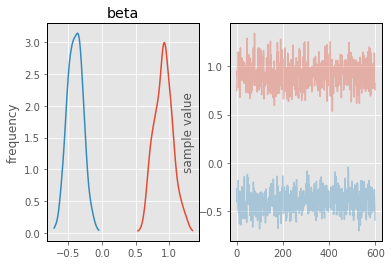

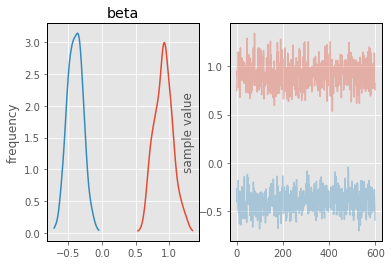

In [135]:
fit.traceplot(['beta'])

Here we notice that by introducing the random walk type baseline hazard, hazards are now more regularized than in the independent gamma prior model (Model 0). This also causes a slight decrese in the effective number of parameters from 24.7 to 22.0.

In [48]:
#np.diff(caches[1]['lambda0'].mean(axis=0), 1).std()

# Psis-loo

In [76]:
from psis import psisloo

In [136]:
log_likelihood1 = caches[2]['log_lik'].reshape(600,-1)#caches[1]['log_lik'].reshape(600,-1)
loo, loos, ks = psisloo(log_likelihood1)
print(np.std(loos))

2.539929205115155


Number of effective parameters:  23.383330702874446
Psis-loo estimate:  -1605.9139453683574


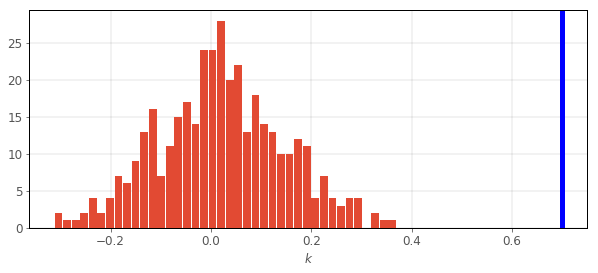

In [137]:
# estimated number of effective parameters
computed_lppd = np.sum(np.log(np.mean(np.exp(log_likelihood1),axis=0)));
pl00cv = computed_lppd - loo;
print("Number of effective parameters:  " + str(pl00cv))
print("Psis-loo estimate:  " + str(computed_lppd))
plt.figure(figsize=(10,4))
plt.hist(ks, bins=40, rwidth=0.9)
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
ylimits=ax.get_ylim()
plt.ylim(ylimits)
plt.plot([0.7, 0.7],[0,100],"b", linewidth=5)
plt.xlabel("$k$")
ax.tick_params(axis='both', which='major', labelsize=12)

In [57]:
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector")

In [154]:
lambda0_ADVI = pystan_utils.vb_extract_variable(fit_ADVI, "lambda0", var_type="vector")

In [159]:
lambda0_ADVI_gp = np.exp(pystan_utils.vb_extract_variable(fit_gp_ADVI, "lambda0", var_type="vector"))

In [198]:
lambda0_ADVI_gp2 = np.exp(pystan_utils.vb_extract_variable(fit_gp_ADVI, "log_lambda0", var_type="vector"))
alpha_ADVI_gp2 = pystan_utils.vb_extract_variable(fit_gp_ADVI, "alpha", var_type="vector")
rho_ADVI_gp2 = pystan_utils.vb_extract_variable(fit_gp_ADVI, "rho", var_type="vector")

In [199]:
print(rho_ADVI_gp2)
print(lambda0_ADVI_gp2)
print(alpha_ADVI_gp2)

[0.10363432]
[0.01215115 0.01220219 0.01083726 0.01041646 0.01018859 0.0059284
 0.01385261 0.00959325 0.0113068  0.01331409 0.01025672 0.02499652
 0.01258632 0.01821134 0.00658827 0.0097913  0.00961441 0.01153941
 0.00745678 0.01223381 0.00974087 0.00686074 0.00873264 0.00407595
 0.01614074 0.02443871]
[3.58369428]


In [225]:
lambda0_ADVI_gp2_no = np.exp(pystan_utils.vb_extract_variable(fit_gp_ADVI_no_loop, "log_lambda0", var_type="vector"))
alpha_ADVI_gp2_no = pystan_utils.vb_extract_variable(fit_gp_ADVI_no_loop, "alpha", var_type="vector")
rho_ADVI_gp2_no = pystan_utils.vb_extract_variable(fit_gp_ADVI_no_loop, "rho", var_type="vector")

In [226]:
print(rho_ADVI_gp2_no)
print(lambda0_ADVI_gp2_no)
print(alpha_ADVI_gp2_no)

[0.10363432]
[0.01216074 0.0122126  0.01084316 0.01042603 0.01019866 0.00593525
 0.01386182 0.00960187 0.01130981 0.01332141 0.01026292 0.02500276
 0.01259797 0.01821919 0.00659453 0.00979893 0.00962339 0.01154859
 0.00746215 0.01223861 0.00974791 0.00686759 0.00873387 0.00408445
 0.01627987 0.02470088]
[3.57296208]


In [290]:
lambda0_ADVI_gp2_no_p = np.exp(pystan_utils.vb_extract_variable(fit_gp_ADVI_no_loop_pred, "log_lambda0", var_type="vector"))
alpha_ADVI_gp2_no_p = pystan_utils.vb_extract_variable(fit_gp_ADVI_no_loop_pred, "alpha", var_type="vector")
rho_ADVI_gp2_no_p = pystan_utils.vb_extract_variable(fit_gp_ADVI_no_loop_pred, "rho", var_type="vector")

print(rho_ADVI_gp2_no_p)
print(lambda0_ADVI_gp2_no_p)
print(alpha_ADVI_gp2_no_p)

[18.70657222]
[0.01522053 0.01189973 0.01047106 0.0098745  0.00974513 0.00970927
 0.00976701 0.01003347 0.01045354 0.01124484 0.01210426 0.01289527
 0.01319304 0.0129252  0.01224565 0.01139105 0.0106383  0.01000566
 0.00940521 0.0087005  0.00785365 0.00699215 0.00634087 0.00613609
 0.00666451 0.0084046  0.01726392 0.01583151 0.01464839 0.01366854
 0.0128661  0.01219898 0.01165542 0.01121247 0.01086185 0.0105703
 0.01034627 0.01016684 0.01003134 0.00993465 0.0098585  0.00979951
 0.00976563 0.00973865 0.00972504 0.00971514 0.00971422 0.00970845
 0.00971837 0.00972498 0.00974087 0.00976335 0.00979967 0.00983616
 0.0098924  0.00996074 0.01004629 0.01014848 0.01026491 0.01039844
 0.01055608 0.01072959 0.01092097 0.01112146 0.01133984 0.01156207
 0.0117863  0.01200846 0.01222762 0.01243994 0.01263081 0.01279762
 0.01294401 0.01305812 0.01313737 0.01318126 0.01318451 0.01315582
 0.01308823 0.01298734 0.01286535 0.01271138 0.01252723 0.01233763
 0.0121313  0.01192104 0.01171121 0.01150061 0.01

In [143]:
lambda0_ADVI_gp_jorg = np.exp(pystan_utils.vb_extract_variable(fit_gp_ADVI, "lambda0", var_type="vector"))
print(np.exp(pystan_utils.vb_extract_variable(fit_gp_ADVI, "rho", var_type="vector")))


[1.05318316]


In [294]:
aa_gp = fit_gp.extract()

In [297]:
print(aa_gp['alpha'][300:].mean(axis=0))
print(np.exp(aa_gp['log_lambda0'][300:]).mean(axis=0))
print(aa_gp['rho'][300:].mean(axis=0))

4.5930377388979835
[1.40118535e-02 1.32101138e-02 9.63055241e-03 1.27508577e-02
 1.08468804e-02 6.35611797e-03 1.34441191e-02 1.12681788e-02
 8.98214880e-03 1.34463568e-02 1.01040259e-02 2.13110331e-02
 1.49507827e-02 1.58926476e-02 7.84818063e-03 1.07412725e-02
 1.17705963e-02 1.36527149e-02 8.11052775e-03 1.17904524e-02
 1.08508939e-02 6.93996399e-03 9.09018170e-03 4.70731424e-03
 4.19488951e-02 1.06212341e-01 2.64998933e+03 2.05300212e+03
 8.07232486e+03 1.31229458e+02 2.99411055e+03 1.16206971e+03
 5.29825791e+02 1.85253547e+04 2.13715630e+06 8.60772386e+02
 3.27805147e+03 2.52648112e+03 1.91782954e+04 1.61289581e+05
 3.99708417e+03 8.98340511e+05 2.13466171e+04 1.43938988e+04
 1.98404274e+03 9.75303800e+04 1.34440033e+05 1.00953787e+03
 6.10859549e+03 2.98000426e+02 1.00185462e+06 2.86985530e+03
 1.08621579e+03 2.12739673e+04 3.13927716e+02 9.63893688e+02
 5.37566136e+03 1.59112261e+03 9.12158968e+03 9.24348032e+03
 1.21114133e+03 4.09575789e+02 2.25262510e+05 3.91474604e+03
 2.28

(0, 0.1)

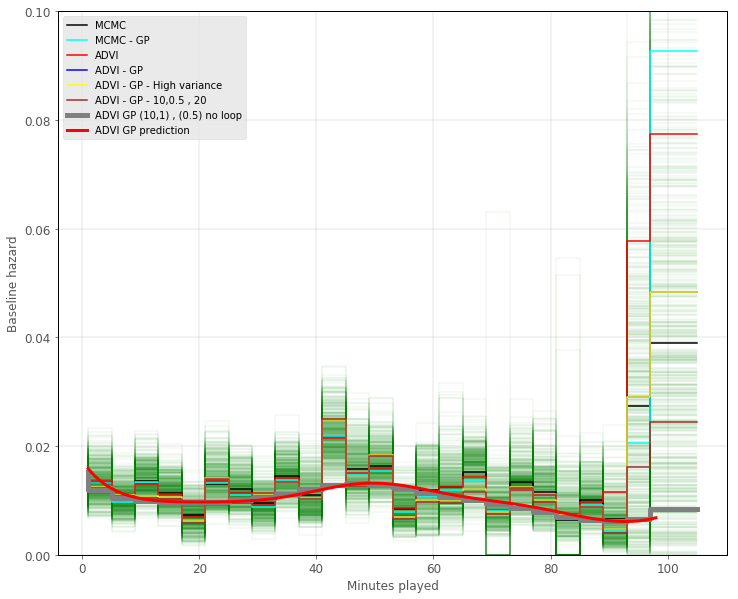

In [291]:
plt.figure(figsize=(12,10))

for i in range(600):
    plt.step(interval_bounds, np.concatenate((aa['lambda0'][i], 
                                              aa['lambda0'][i][-1]),axis=None),c='green' , linewidth=0.08)
plt.step(interval_bounds, np.concatenate((aa['lambda0'].mean(axis=0), 
                                          aa['lambda0'].mean(axis=0)[-1]),axis=None),c='black', label='MCMC')

plt.step(interval_bounds, np.concatenate((np.exp(aa_gp['log_lambda0'][300:]).mean(axis=0), 
                                          np.exp(aa_gp['log_lambda0'][300:]).mean(axis=0)[-1]),axis=None),c='cyan', label='MCMC - GP')


    
plt.step(interval_bounds, np.concatenate((lambda0_ADVI, 
                                          lambda0_ADVI[-1]),axis=None),c='red', label='ADVI')
plt.step(interval_bounds, np.concatenate((lambda0_ADVI_gp, 
                                          lambda0_ADVI_gp[-1]),axis=None),c='blue',label='ADVI - GP' )
plt.step(interval_bounds, np.concatenate((lambda0_ADVI_gp_jorg, 
                                          lambda0_ADVI_gp_jorg[-1]),axis=None),c='yellow',label='ADVI - GP - High variance' )
plt.step(interval_bounds, np.concatenate((lambda0_ADVI_gp2, 
                                          lambda0_ADVI_gp2[-1]),axis=None),c='brown',label='ADVI - GP - 10,0.5 , 20' )
plt.step(interval_bounds, np.concatenate((lambda0_ADVI_gp2_no_p[:n_intervals], 
                                          lambda0_ADVI_gp2_no_p[:n_intervals][-1]),axis=None),c='grey',label='ADVI GP (10,1) , (0.5) no loop', linewidth=5 )
plt.plot(np.arange(1,99),lambda0_ADVI_gp2_no_p[n_intervals+1:] ,c='red',label='ADVI GP prediction', linewidth=3 )
plt.legend()
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.xlabel("Minutes played", fontsize=12)
plt.ylabel("Baseline hazard", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0, 0.10])

# Conclusion: The test therapy reduces the average hazard by approximately 8%

In [295]:
np.exp(aa_gp['beta'][300:].mean())

1.529593512227316

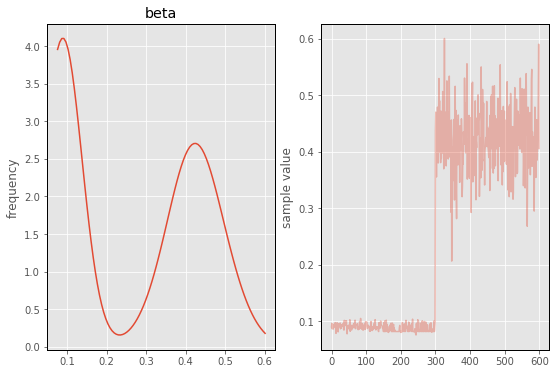

In [296]:
fit_gp.traceplot('beta');

# Psis-loo

In [97]:
from psis import psisloo

In [98]:
np.shape(aa['log_lik'])

(600, 380)

In [217]:
log_likelihood1 = aa_gp['log_lik'][300:].reshape(300,-1)
loo, loos, ks = psisloo(log_likelihood1)

In [218]:
log_likelihood1

array([[-7.04558383, -0.42727424, -1.98591602, ..., -3.8857505 ,
        -0.12376392, -3.77127874],
       [-7.46763269, -0.55925089, -1.84978292, ..., -3.71324483,
        -0.08042162, -3.94418968],
       [-7.79208686, -0.50064448, -2.01238647, ..., -3.47760179,
        -0.07769376, -3.85979865],
       ...,
       [-7.51514697, -0.47918478, -1.80376021, ..., -3.4987298 ,
        -0.08859388, -3.73869975],
       [-7.8089017 , -0.47219346, -1.95167951, ..., -3.85702904,
        -0.066273  , -3.43254756],
       [-7.51464622, -0.39439408, -1.74230655, ..., -3.7689898 ,
        -0.08328553, -3.70229554]])

In [219]:
np.std(loos)

2.6342669348506607

Number of effective parameters:  26.018162703606777
Psis-loo estimate:  -1606.311680056156


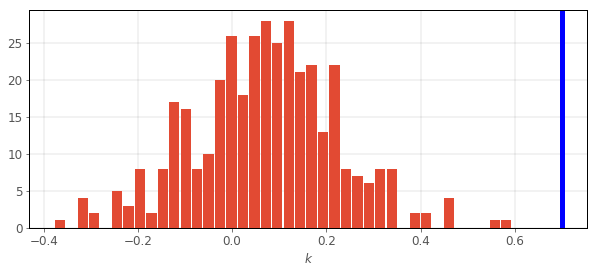

In [220]:
# estimated number of effective parameters
computed_lppd = np.sum(np.log(np.mean(np.exp(log_likelihood1),axis=0)));
pl00cv = computed_lppd - loo;
print("Number of effective parameters:  " + str(pl00cv))
print("Psis-loo estimate:  " + str(computed_lppd))
plt.figure(figsize=(10,4))
plt.hist(ks, bins=40, rwidth=0.9)
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
ylimits=ax.get_ylim()
plt.ylim(ylimits)
plt.plot([0.7, 0.7],[0,100],"b", linewidth=5)
plt.xlabel("$k$")
ax.tick_params(axis='both', which='major', labelsize=12)

# STAN Model - Gaussian Process

In [ ]:
interval_start = interval_bounds[:-1].astype(float)[:, np.newaxis]+(interval_length-1)/2

In [268]:
x2 = np.arange(1,100).astype(float)[:, np.newaxis]

In [272]:
len(x2)

99

In [273]:
death_dat4 ={'N':              len(df),
             'N_tot':          N_tot_new + N_tot_new2,
             'T':              n_intervals,
             'M':              1,
             'base_id':        np.concatenate((base_id_new, base_id_new2), axis=None),
             'death_array':    np.concatenate((death_array_new, death_array_new2), axis=None),
             'x':              np.concatenate((skill_gap_array_new, skill_gap_array_new2), axis=None),
             'expo':           np.concatenate((expo_new, expo_new2), axis=None),
             'match_id':       match_id,
             'interval_start': interval_start,
             'x2':             x2,
             'N2':             len(x2),
             'T_gp':           n_intervals + len(x2),
             't_axis':         np.concatenate((interval_start, x2))}

In [287]:
gp_model="""
functions {
  ///// Automatic Relevance Determination - taken from manual ////
  matrix L_cov_exp_quad_ARD(vector[] x,
                            real alpha,
                            vector rho,
                            real delta) {
    int N = size(x);
    matrix[N, N] K;
    real sq_alpha = square(alpha);
    for (i in 1:(N-1)) {
      K[i, i] = sq_alpha + delta;
      for (j in (i + 1):N) {
        K[i, j] = sq_alpha
                      * exp(-0.5 * dot_self((x[i] - x[j]) ./ rho));
        K[j, i] = K[i, j];
      }
    }
    K[N, N] = sq_alpha + delta;
    return cholesky_decompose(K);
  }
}
data {
  int<lower=1> N;          // number of matches
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  int<lower=1> T_gp;       // number of time intervals (training) + additional time points for gp predictions
  //int<lower=0> M;        // number of covariates
  vector[N_tot] x;         // covariate array
  int<lower=0, upper=T> base_id[N_tot];  // index of time interval for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // Observation array: 1 for observed goal, 
                                               // and 0 if no more goals or away goal.
  vector<lower=0>[N_tot] expo;                 // Exposure time in each interval

  int match_id[N_tot];          // (should be  <lower=0, upper=N>)
  vector[1] interval_start[T];  // minute of begining of each time interval (real<lower=0>interval_start[T];)
  
  vector[1] t_axis[T_gp];
  // For Gaussian process prediction:
  // int<lower=1> N1;    // = T
  //real x1[N1];         // = interval_start
  //vector[N1] y1;       // = death_array
  int<lower=1> N2;       
  vector[1] x2[N2];
}

transformed data {
  real delta = 1e-5;                   // additional noise for covariance diagonal
  vector[N_tot] log_expo = log(expo);  // log-duration for each timepoint
  //vector[T] mu = rep_vector(0, T);   // mean vector for Gaussian process
  
  //vector[1] t_axis[T_gp];
  //for (n1 in 1:T) t_axis[n1] = interval_start[n1];
  //for (n2 in 1:N2) t_axis[T + n2] = x2[n2];
}
parameters {
  real beta;                       // regression coefficient of covariates
  
  vector<lower=0>[1] rho;          // Gaussian process scale parameter (vector due to L_cov_exp_quad_ARD)
  real<lower=0> alpha;             // Gaussian process scale parameter
  vector[T_gp] eta;                // for sampling from multivariate normal using Cholesky scheme

}
transformed parameters{
  vector[T_gp] log_lambda0;           // log of baseline hazard for each timepoint t
  
  ////  Gaussian Process with Automatic Relevance Determination: ////
  matrix[T_gp, T_gp] L_K = L_cov_exp_quad_ARD(t_axis, alpha, rho, delta); 
  log_lambda0 = L_K * eta;
}
model {
  beta ~ normal(0, 3);
  
  rho ~ inv_gamma(10,1);
  alpha ~ normal(0,5);
  eta ~ normal(0,1);
  
  death_array ~ poisson_log(log_lambda0[base_id] + log_expo + x * beta );
}
generated quantities {
  vector[N] log_lik = rep_vector(0,N);
  
  // PSIS-LOO, i.e. leave one match out cross validation.
  for (n_tot in 1:N_tot) { 
      log_lik[match_id[n_tot]+1] += poisson_log_lpmf(death_array[n_tot]| log_lambda0[base_id[n_tot]]+log_expo[n_tot]+x[n_tot]*beta);
  }
  
  // PREDICTIVE INFERENCE:
  //real y2[N2];
  //y2 = log_lambda0[1+T: T_gp]
}
"""

In [288]:
sm_gp = pystan.StanModel(model_code=gp_model);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_679e780e2da6e1e83454985bb5520c1c NOW.
/home/bjarke/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp95c3l3ix/stanfit4anon_model_679e780e2da6e1e83454985bb5520c1c_7949933561827109303.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [292]:
fit_gp = sm_gp.sampling(data=death_dat4, algorithm="HMC", seed=3, iter=200, chains=4, warmup=50)

In [289]:
fit_gp_ADVI_no_loop_pred = sm_gp.vb(data=death_dat4, iter=15000, algorithm="meanfield", elbo_samples=1000, grad_samples=1, seed=42, verbose=True)

# Time varying coefficient

In [ ]:
survival_model_time_varying="""
data {
  int<lower=1> N;          // number of individuals
  int<lower=1> N_tot;      // total number of pseudo poisson observations
  int<lower=1> T;          // number of time intervals
  //int<lower=0> M;        // number of covariates
  int<lower=0, upper=40> base_id[N_tot];  // time interval index for each pseudo obs.
  
  int<lower=0, upper=1> death_array[N_tot];    // 1 for observed death, 0 all other cases
  vector[N_tot] x;                             // covariates

  vector<lower=0>[N_tot] expo;  // exposure time (time alive) in each interval
}

transformed data {
  vector[N_tot] log_expo = log(expo);  // log-duration for each timepoint
  // vector[N_tot] xx = 1-x;
}
parameters {
  vector[T] beta;              // regression coefficient
  vector<lower=0>[T] lambda0;  // baseline hazard for each timepoint t
}
model {
  beta ~ normal(0, 1);
  lambda0 ~ gamma(0.01,0.1);
  for (n_tot in 1:N_tot) {
    death_array[n_tot] ~ poisson_log(log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta[base_id[n_tot]]);
  }
  
}
generated quantities {
  vector[N] log_lik;
  int n; 
  n = 1;
  log_lik = rep_vector(0,N);
  
  // log_lik for loo-psis
  for (n_tot in 1:N_tot) { 
      log_lik[n] += poisson_log_lpmf(death_array[n_tot]| log(lambda0[base_id[n_tot]])+log_expo[n_tot]+x[n_tot]*beta );
      
      // increment individual count if next time interval comes before the current 
      // only because of bad programming
      if (n_tot > 1){
          if (base_id[n_tot] <= base_id[n_tot-1]){
              n += 1;  
          }
      }
  }
}
"""